# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [77]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [78]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 20)
df_test, df_val = train_test_split(df_temp, test_size = 0.5, random_state = 21)

In [79]:
y_train = df_train['salary_in_usd']
y_test = df_test['salary_in_usd']
y_val = df_val['salary_in_usd']

X_train = df_train.drop(['salary_in_usd'], axis = 1)
X_test = df_test.drop(['salary_in_usd'], axis = 1)
X_val = df_val.drop(['salary_in_usd'], axis = 1)

X_train = X_train.drop(['salary'], axis = 1)
X_test = X_test.drop(['salary'], axis = 1)
X_val = X_val.drop(['salary'], axis = 1)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = X_train.select_dtypes(include = ['object']).columns.tolist()


encoder = OneHotEncoder(handle_unknown='ignore')


X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

model = LinearRegression()
model.fit(X_train_encoded, y_train)

test_predictions = model.predict(X_test_encoded)
val_predictions = model.predict(X_val_encoded)

print('MAPE TEST:', mean_absolute_percentage_error(y_test, test_predictions))
print('RMSE TEST:', mean_squared_error(y_test, test_predictions, squared=False))

print('MAPE VALIDATION:', mean_absolute_percentage_error(y_val, val_predictions))
print('RMSE VALIDATION:', mean_squared_error(y_val, val_predictions, squared=False))

MAPE TEST: 0.3743619235410565
RMSE TEST: 48880.67738351015
MAPE VALIDATION: 0.4489514852302915
RMSE VALIDATION: 51634.04932203343


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [81]:
pip install xgboost

In [87]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time
import xgboost as xgb

params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1]
}

xgb_model = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
end_time = time.time()

best_params = grid_search.best_params_
print("Лучшие параметры:")
print(best_params)
print(end_time - start_time)

Best parameters found by GridSearchCV:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
11.618800163269043


In [88]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train_encoded, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [89]:
y_pred = model.predict(X_test_encoded)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared = False))

MAPE:  0.3332796972686136
RMSE:  44569.8031747718


Качество модели оставляет желать лучшего... Однако, учтём, что мы подбираем из двух значений четырёх параметров, модель можно улучшить, покрутив параметры. Но зато, мы подобрали их за 11.6 секунд!

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [91]:
pip install catboost

In [95]:
from catboost import CatBoostRegressor
import catboost as ctb

params = {
    'depth' : [3, 5],
    'learning_rate' : [0.1, 0.2],
    'iterations' : [100, 200],
}

cb_model_model = CatBoostRegressor()

grid_search = GridSearchCV(estimator=cb_model_model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
end_time = time.time()

best_params = grid_search.best_params_
print("Лучшие параметры:")
print(best_params)
print(end_time - start_time)

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 56949.5182013	total: 4.31ms	remaining: 211ms
4:	learn: 55805.4314967	total: 5.22ms	remaining: 204ms
5:	learn: 54964.4659330	total: 6.13ms	remaining: 198ms
6:	learn: 54271.3358001	total: 7.02ms	remaining: 194ms
7:	learn: 53619.5166558	total: 7.93ms	remaining: 190ms
8:	learn: 53060.5571846	total: 8.88ms	remaining: 189ms
9:	learn: 52457.2189599	total: 9.77ms	remaining: 186ms
10:	learn: 51901.8319900	total: 10.7ms	remaining: 183ms
11:	learn: 51600.4919204	total: 11.6ms	remaining: 182ms
12:	learn: 51202.4812671	total: 12.6ms	remaining: 181ms
13:	learn: 50907.4426157	total: 13.5ms	remaining: 179ms
14:	learn: 50581.6746736	total: 14.4ms	remaining: 178ms
15:	learn: 50394.4292578	total: 15.3ms	remaining: 176ms
16:	learn: 50130.4440815	total: 16.4ms	remaining: 177ms
17:	learn: 49998.7685712	total: 17.2ms	remaining: 174ms
18:	learn: 49897.0725184	total: 18.1ms	remaining: 173ms
19:	learn: 49805.8990413	total: 19ms	remain

In [93]:
model = ctb.CatBoostRegressor(**best_params)
model.fit(X_train_encoded, y_train)

0:	learn: 59068.2046061	total: 2.05ms	remaining: 409ms
1:	learn: 56092.6862483	total: 3.99ms	remaining: 395ms
2:	learn: 54141.4813108	total: 7.14ms	remaining: 469ms
3:	learn: 52573.3509556	total: 10.6ms	remaining: 519ms
4:	learn: 51563.4543237	total: 12ms	remaining: 469ms
5:	learn: 50889.4778163	total: 13.3ms	remaining: 431ms
6:	learn: 50365.1507584	total: 14.8ms	remaining: 407ms
7:	learn: 49962.7763406	total: 16.2ms	remaining: 388ms
8:	learn: 49559.0413025	total: 17.7ms	remaining: 375ms
9:	learn: 49370.2144404	total: 19.1ms	remaining: 363ms
10:	learn: 49175.6024454	total: 20.6ms	remaining: 353ms
11:	learn: 48996.4711261	total: 22ms	remaining: 344ms
12:	learn: 48835.0972450	total: 23.4ms	remaining: 336ms
13:	learn: 48752.0826442	total: 24.7ms	remaining: 328ms
14:	learn: 48732.9672710	total: 25.7ms	remaining: 317ms
15:	learn: 48577.1519416	total: 27.2ms	remaining: 313ms
16:	learn: 48529.7220249	total: 28.9ms	remaining: 311ms
17:	learn: 48365.9780367	total: 30.4ms	remaining: 307ms
18:	le

In [94]:
y_pred = model.predict(X_test_encoded)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared = False))

MAPE:  0.3264376142779585
RMSE:  44235.340394431274


Что сказать... Всё же, эта модель отработала чуть лучше, ошибка предикта меньше, и мы потратили на это 11.8 секунд, что отлично всего на 0.2 от xgboost

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [98]:
from catboost import Pool
import catboost as cb

train_pool = cb.Pool(X_train, y_train, cat_features= categorical_features)

params = {
    'learning_rate': [0.01, 0.05],
    'depth': [4, 6],
    'iterations': [100, 200]
}


grid_search = GridSearchCV(estimator=CatBoostRegressor(), param_grid=params, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
end_time = time.time()

best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:")
print(best_params)


best_catboost_model = CatBoostRegressor(**best_params)


best_catboost_model.fit(train_pool)

test_pool = Pool(X_test, cat_features=categorical_features)
test_predictions_catboost = best_catboost_model.predict(test_pool)

mape_catboost = mean_absolute_percentage_error(y_test, test_predictions_catboost)
rmse_catboost = mean_squared_error(y_test, test_predictions_catboost, squared=False)

print(f'MAPE на тестовом сете: {mape_catboost}')
print(f'RMSE на тестовом сете): {rmse_catboost}')
print(f'Время на поиск оптимальных параметров и на обучение: {end_time - start_time} seconds')

Выходные данные были обрезаны до нескольких последних строк (5000).
5:	learn: 61051.3866826	total: 6.39ms	remaining: 207ms
6:	learn: 60873.9628213	total: 7.48ms	remaining: 206ms
7:	learn: 60703.4162568	total: 8.31ms	remaining: 199ms
8:	learn: 60529.3420530	total: 9.32ms	remaining: 198ms
9:	learn: 60354.8067060	total: 10.4ms	remaining: 198ms
10:	learn: 60163.3914219	total: 11.8ms	remaining: 203ms
11:	learn: 60003.7595125	total: 12.8ms	remaining: 200ms
12:	learn: 59860.2450227	total: 13.9ms	remaining: 200ms
13:	learn: 59725.4321049	total: 15ms	remaining: 199ms
14:	learn: 59568.4191306	total: 17ms	remaining: 210ms
15:	learn: 59403.7498466	total: 18.9ms	remaining: 217ms
16:	learn: 59232.3877171	total: 20.7ms	remaining: 222ms
17:	learn: 59076.2007648	total: 22.3ms	remaining: 226ms
18:	learn: 58953.1077023	total: 24.1ms	remaining: 230ms
19:	learn: 58808.6404090	total: 25.7ms	remaining: 231ms
20:	learn: 58675.5482131	total: 26.9ms	remaining: 229ms
21:	learn: 58543.6099775	total: 27.9ms	remain

Нет, стало хуже. Возрасла и ошибка и время обучения. Однако, не будем забывать, что в этом варианте мы не тратили время на отдельное OHE

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [104]:
from lightgbm import LGBMRegressor


params = {
    'max_depth' : [3, 5],
    'learning_rate' : [0.1, 0.2],
    'n_estimators' : [100, 200],
    'num_leaves' : [3, 5]
}

lgbm_model_model = LGBMRegressor()

grid_search = GridSearchCV(estimator=lgbm_model_model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
end_time = time.time()

best_params = grid_search.best_params_
print("Лучшие параметры:")
print(best_params)
print(end_time - start_time)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 2403, number of used features: 37
[LightGBM] [Info] Start training from score 138743.270079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 2403, number of used features: 37
[LightGBM] [Info] Start training from score 138885.720766
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [105]:
import lightgbm as lgbm

In [106]:
model = lgbm.LGBMRegressor(**best_params)
model.fit(X_train_encoded, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 40
[LightGBM] [Info] Start training from score 138675.276298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(learning_rate=0.2, max_depth=3, num_leaves=5)

In [107]:
y_pred = model.predict(X_test_encoded)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared = False))

MAPE:  0.347657710409997
RMSE:  45877.02453419008


На LGBM мы видим другую картину... Ошибка чуть-чуть возрасла, зато обучение модели уменьшилось в несколько раз, аж до 3.5 секунд!

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** На этих трёх моделях можно чётко проследить как меняется скорость обучения/количество гиперпараметров/и количество их значений, так что стоит находить компромисс между ними, чтобы добиться оптимальных результатов по всем фронтам.

---

Я считаю, что из всех наших моделей лучшая - LightGBM, ведь она даёт практически идентичные прогнозы, но работает в несколько раз быстрее! А всё из-за подхода leaf-wise обучения

---

В целом, гиперпараметры моделей схожи, однако различаются из-за определённых подходов к обучению

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [74]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [109]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [110]:
ratings = ratings.drop(['user'],axis = 0)

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [111]:
ratings.fillna(0, inplace=True)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
tiësto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [113]:
cluster_labels = kmeans.labels_
cluster_labels

array([3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [114]:
import numpy as np

In [115]:
cluster_sizes = np.bincount(cluster_labels)
cluster_sizes

array([  2,   1, 995,   1,   1])

**Ответ:** Не могу сказать, что кластеризация особенно полезна, ведь KMeans выдало нам 3 кластера с 1 элементом

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [116]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)

cluster_labels = kmeans.labels_

cluster_sizes = np.bincount(cluster_labels)

clusters_of_size_one = np.where(cluster_sizes == 1)[0]

artists_in_clusters_of_size_one = ratings.index[np.isin(cluster_labels, clusters_of_size_one)]
print(artists_in_clusters_of_size_one)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Index(['the beatles', 'coldplay', '보아'], dtype='object')


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [119]:
artist_listen = (ratings > 0).sum(axis=1) / ratings.shape[1]


average_listen = artist_listen.mean()


the_beatles_listen_fraction = artist_listen_fractions.loc['the beatles']

print("Средняя доля прослушивания всех исполнителей:", average_listen)
print("Доля прослушивания для The Beatles:", the_beatles_listen_fraction)

Средняя доля прослушивания всех исполнителей: 0.026826200000000005
Доля прослушивания для The Beatles: 0.3342


**Ответ:** Всё становится ясно, The beatles слишком популярна их доля прослушиваний составляет 33,4%

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [120]:
from sklearn.preprocessing import normalize

normalized_data = normalize(ratings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [121]:
kmeans = KMeans(n_clusters=5, random_state=36)
kmeans.fit(normalized_data)


cluster_labels = kmeans.labels_


cluster_sizes = pd.Series(cluster_labels).value_counts()

print("Размеры кластеров после нормализации:", cluster_sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Размеры кластеров после нормализации: 3    474
2    264
1    113
4     76
0     73
Name: count, dtype: int64


In [122]:
cluster_labels = kmeans.labels_
cluster_labels

array([3, 2, 2, 3, 2, 2, 2, 3, 3, 1, 4, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3,
       2, 3, 2, 2, 2, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 0, 0,
       1, 2, 3, 3, 2, 3, 2, 3, 4, 3, 3, 2, 3, 2, 3, 2, 2, 2, 4, 2, 3, 3,
       2, 2, 0, 4, 2, 2, 2, 1, 3, 1, 2, 2, 3, 3, 0, 2, 2, 2, 3, 2, 3, 3,
       3, 2, 3, 3, 2, 3, 2, 3, 1, 0, 3, 2, 2, 3, 3, 2, 0, 4, 1, 2, 3, 2,
       3, 3, 3, 0, 1, 1, 3, 0, 2, 1, 3, 3, 4, 2, 2, 3, 2, 3, 1, 3, 3, 3,
       1, 1, 2, 3, 3, 1, 3, 3, 3, 4, 2, 2, 1, 2, 2, 2, 2, 3, 4, 1, 3, 1,
       3, 1, 2, 2, 2, 1, 3, 4, 2, 4, 0, 4, 2, 1, 3, 0, 4, 2, 1, 3, 1, 1,
       3, 2, 3, 2, 3, 1, 0, 3, 0, 4, 3, 0, 0, 4, 1, 3, 3, 4, 2, 2, 2, 1,
       3, 3, 2, 3, 2, 3, 3, 3, 0, 1, 0, 0, 3, 3, 3, 3, 3, 4, 3, 1, 3, 2,
       1, 3, 2, 3, 2, 3, 3, 2, 0, 2, 3, 0, 3, 2, 2, 3, 1, 2, 4, 1, 2, 4,
       0, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 4, 1, 0,
       3, 3, 2, 3, 2, 2, 1, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2,
       0, 4, 3, 3, 0, 3, 3, 1, 2, 3, 3, 3, 1, 3, 2,

In [123]:
cluster_sizes = np.bincount(cluster_labels)
cluster_sizes

array([ 73, 113, 264, 474,  76])

**Ответ** Да, стало явно лучше, теперь нет кластеров с одним объектом, это более информативно

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [124]:
from scipy.spatial.distance import cosine

centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

normalized_df = pd.DataFrame(normalized_data, index=ratings.index)

def get_top_performers(centroid, data, top_n=10):
    distances = data.apply(lambda row: cosine(centroid, row), axis=1)
    return distances.nsmallest(top_n).index.tolist()

top_performers_per_cluster = {i: get_top_performers(centroid, normalized_df) for i, centroid in enumerate(centroids)}

for cluster_id, performers in top_performers_per_cluster.items():
    print(f"Топ-10 исполнителей для кластера {cluster_id}:")
    for performer in performers:
        print(performer)
    print("\n")

Топ-10 исполнителей для кластера 0:
fall out boy
saosin
cartel
taking back sunday
all time low
brand new
mayday parade
new found glory
the starting line
cute is what we aim for


Топ-10 исполнителей для кластера 1:
nas
jay-z
kanye west
a tribe called quest
the roots featuring d'angelo
lupe the gorilla
mos def
little brother
gangstarr
de la soul


Топ-10 исполнителей для кластера 2:
radiohead
the arcade fire
belle and sebastian
broken social scene
sufjan stevens
animal collective
the shins
modest mouse
the pixies
of montreal


Топ-10 исполнителей для кластера 3:
the beatles
coldplay
the killers
radiohead
u2
red hot clili peppers
led zeppelin.
john mayer
deathcab for cutie
the rolling stones


Топ-10 исполнителей для кластера 4:
metallica
iron maiden
slayer
megadeth
pantera
koЯn
mudvayne
in flames
system of a down
cob




**Ответ:** Очень похоже на то, что кластеры разбились по определённым жанрам в музыке, это логично, потому что пользователи предпочитают определённые жанры и выбирают новых исполнителей на основе старых

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

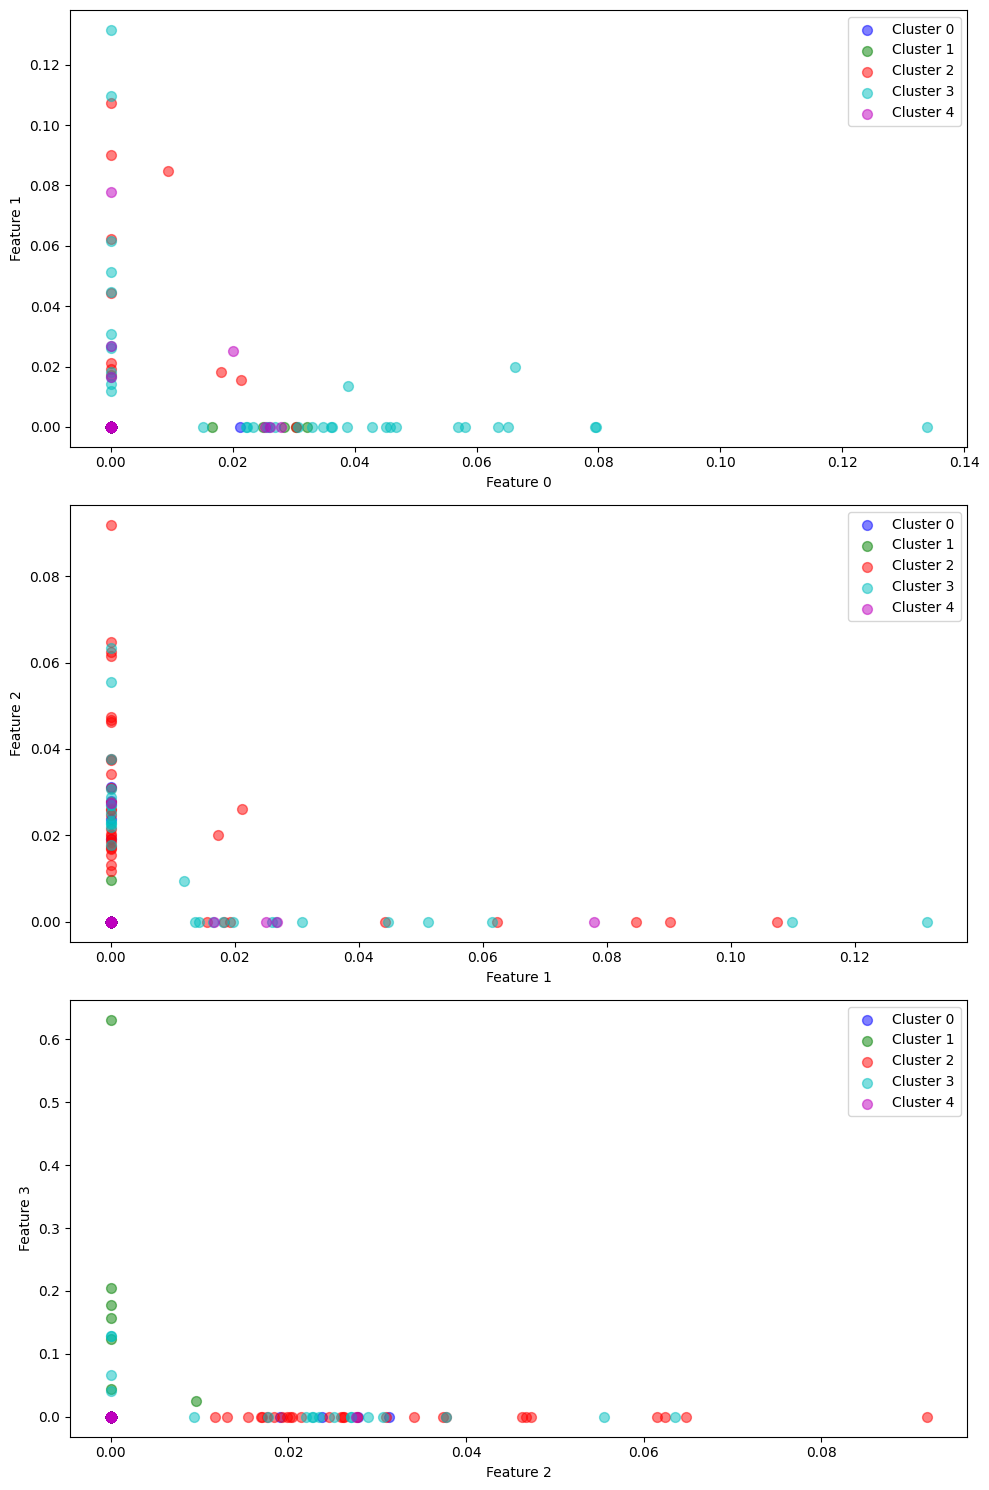

In [125]:
import matplotlib.pyplot as plt

normalized_df = pd.DataFrame(normalized_data, index=ratings.index)

normalized_df['cluster'] = cluster_labels


pairs_of_features = [(0, 1), (1, 2), (2, 3)]
colors = ['b', 'g', 'r', 'c', 'm']

fig, axes = plt.subplots(len(pairs_of_features), 1, figsize=(10, 15))

for (i, (x_idx, y_idx)) in enumerate(pairs_of_features):
    for cluster in range(5):
        cluster_data = normalized_df[normalized_df['cluster'] == cluster]
        axes[i].scatter(cluster_data.iloc[:, x_idx], cluster_data.iloc[:, y_idx], s=50, c=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)
    axes[i].set_xlabel(f'Feature {x_idx}')
    axes[i].set_ylabel(f'Feature {y_idx}')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Ответ:** Ну, что-то понять из них можно... но графики не особо информативны. Однако, они отражают распределение на кластеры, ведь точки одинаковых цветов находятся крайне близко друг к другу

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

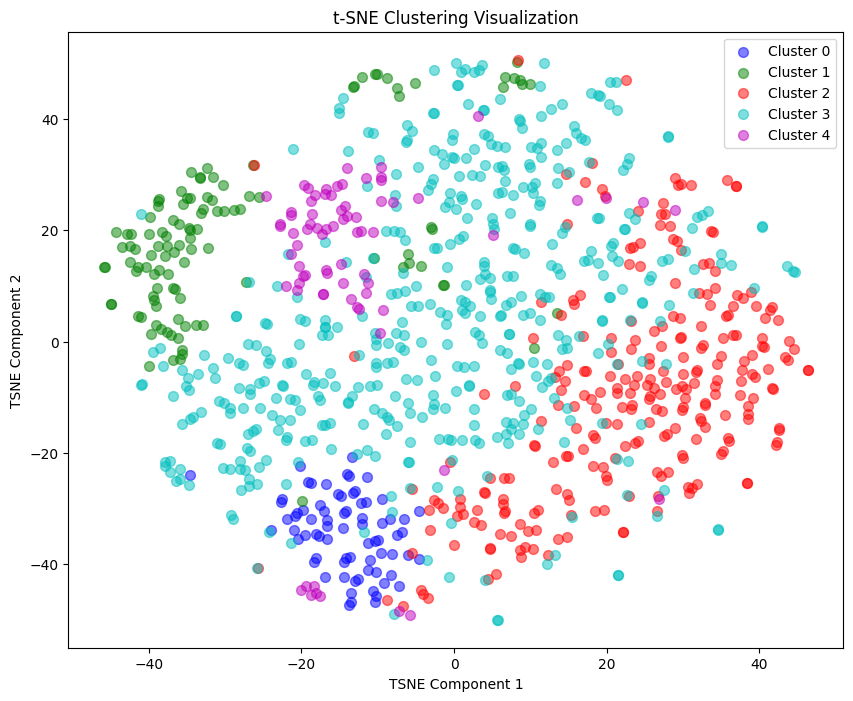

In [126]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(normalized_data)


tsne_df = pd.DataFrame(tsne_result, index=ratings.index)
tsne_df['cluster'] = cluster_labels


plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm']

for cluster in range(5):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster]
    plt.scatter(cluster_data[0], cluster_data[1], s=50, c=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.title('t-SNE Кластеризация')
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

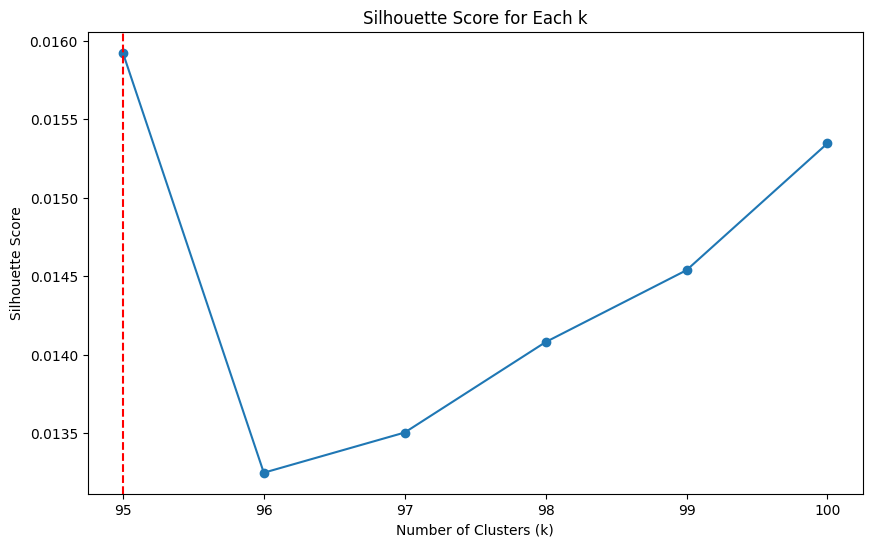

Optimal number of clusters: 95


In [127]:
from sklearn.metrics import silhouette_score


range_n_clusters = range(95, 101)


silhouette_scores = []


for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)


optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]


plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Номер кластера (k)')
plt.ylabel('индекс Силуэта')
plt.title('индекс Силуэта для каждого k')
plt.axvline(x=optimal_n_clusters, color='r', linestyle='--')
plt.show()

print(f'Оптимальное число кластеров: {optimal_n_clusters}')

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [135]:
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=36)
cluster_labels = kmeans.fit_predict(normalized_data)
centroids = kmeans.cluster_centers_


def get_closest_artists(data, centroids, top_n=10):
    closest_artists = {}
    for i, center in enumerate(centroids):
        distances = np.linalg.norm(data - center, axis=1)
        closest_indices = np.argsort(distances)[:top_n]
        closest_artists[i] = [(ratings.index[idx], distances[idx]) for idx in closest_indices]
    return closest_artists

closest_artists = get_closest_artists(normalized_data, centroids)


print("Топ 10 артистов возле каждого центроида:")
for cluster_id, artists in closest_artists.items():
    print(f"Cluster {cluster_id}:")
    for rank, (artist_name, distance) in enumerate(artists, start=1):
        print(f"  {rank}. {artist_name}, расстояние: {distance:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Top 10 closest artists to each cluster centroid:
Cluster 0:
  1. stars of the lid, Distance: 0.6025
  2. eluvium, Distance: 0.6903
  3. eno, Distance: 0.7814
  4. talking heads, Distance: 1.1443
  5. aphex twin, Distance: 1.1457
  6. m83, Distance: 1.1651
  7. tortoise, Distance: 1.1683
  8. boards of canada, Distance: 1.1711
  9. slowdive, Distance: 1.1750
  10. the album leaf, Distance: 1.1767
Cluster 1:
  1. kings of leon, Distance: 0.8262
  2. the strokes, Distance: 0.8791
  3. kasabian, Distance: 0.8818
  4. mgmt, Distance: 0.8995
  5. black rebel motorcycle club, Distance: 0.9027
  6. cold war kids, Distance: 0.9097
  7. lou reed, Distance: 0.9336
  8. the arctic monkeys, Distance: 1.0078
  9. interpol, Distance: 1.0177
  10. the shins, Distance: 1.0241
Cluster 2:
  1. bloc party, Distance: 0.8582
  2. the arctic monkeys, Distance: 0.9053
  3. the editors, Distance: 0.9210
  4. interpol, Distance: 0.9235
  5. foals, Distance: 0.9261
  6. tokyo police club, Distance: 0.9290
  7. c

**Ответ:** Да, смысл остался прежним. Рассмотрим, к примеру, кластер под номером 78, там находится классическая музыка

Сделайте t-SNE визуализацию полученной кластеризации.

<ipython-input-139-d405eb77360b>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', optimal_n_clusters)


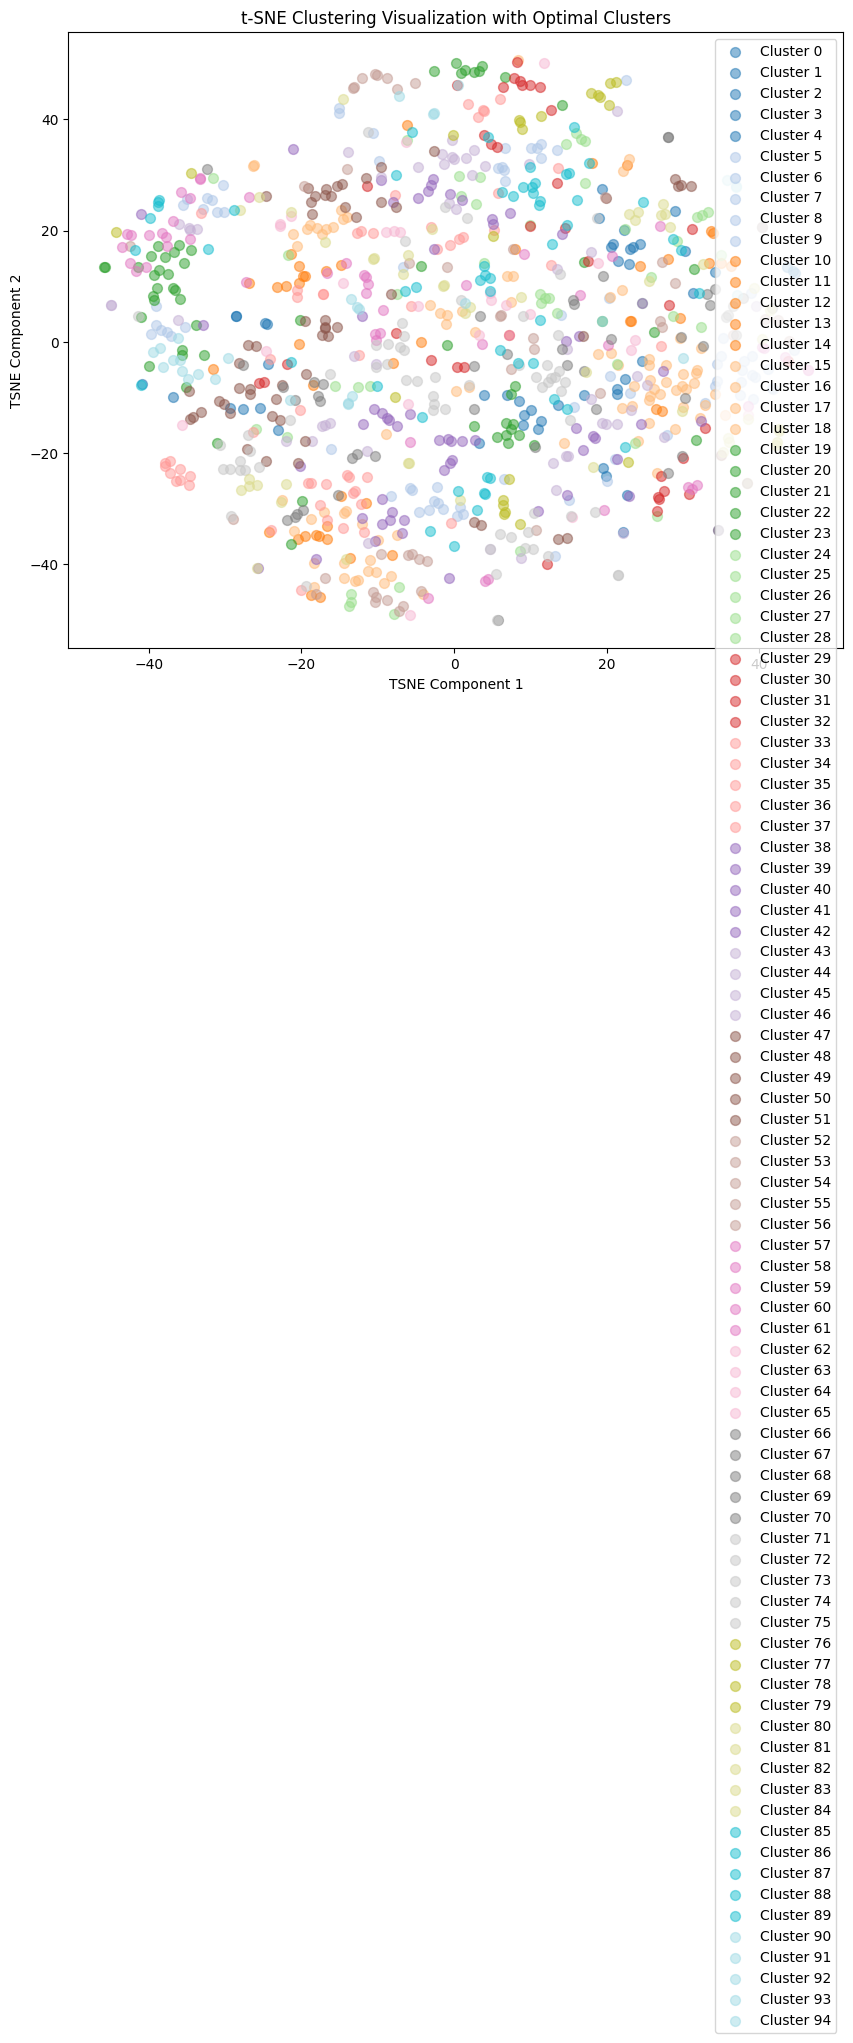

In [139]:
tsne_result_optimal = tsne.fit_transform(normalized_data)
tsne_df_optimal = pd.DataFrame(tsne_result_optimal, index=ratings.index)
tsne_df_optimal['cluster'] = cluster_labels
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', optimal_n_clusters)
for cluster in range(optimal_n_clusters):
    cluster_data = tsne_df_optimal[tsne_df_optimal['cluster'] == cluster]
    plt.scatter(cluster_data[0], cluster_data[1], s=50, c=[colors(cluster)], label=f'Cluster {cluster}', alpha=0.5)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.title('t-SNE кластеризация с оптимальным числом кластеров')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

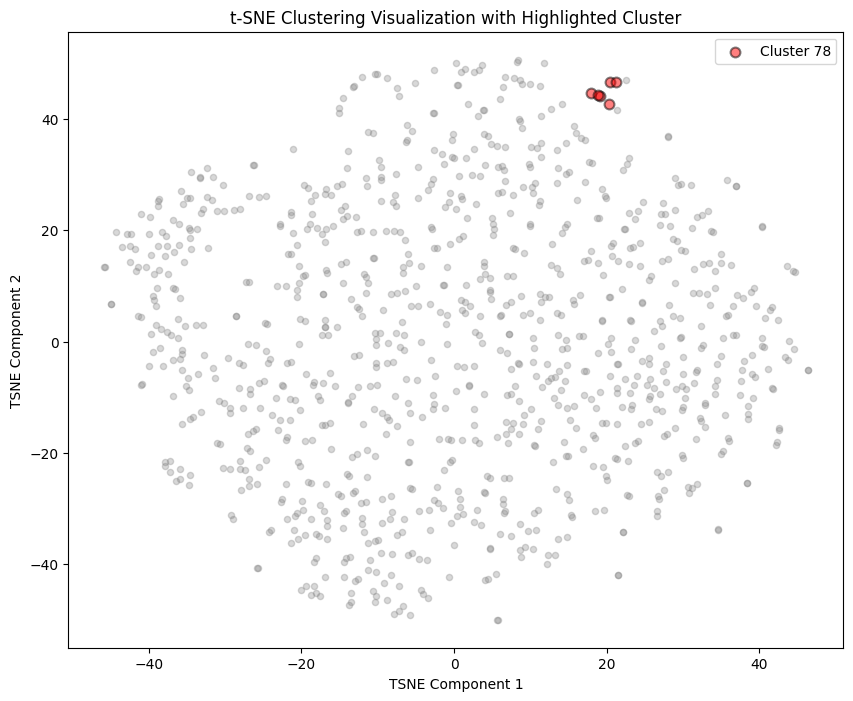

In [141]:
interesting_cluster_id = 78

plt.figure(figsize=(10, 8))

for cluster in range(optimal_n_clusters):
    cluster_data = tsne_df_optimal[tsne_df_optimal['cluster'] == cluster]
    if cluster == interesting_cluster_id:
        plt.scatter(cluster_data[0], cluster_data[1], s=50, label=f'Cluster {cluster}', color='red', alpha=0.5, edgecolor='k', linewidth=1.5)
    else:
        plt.scatter(cluster_data[0], cluster_data[1], s=20, color='gray', alpha=0.3)

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.title('t-SNE кластеризация с выделенным классом')
plt.show()

**Ответ:** Мы рассмотрели интересный кластер под номером 78, где находятся исполнители классической музыки. И при их выделении они находятся рядом, кластеризация сработала верно!